## Hex GNN Experimentation

In [1]:
NUMAGENTS = 30
NUMEXPERIMENTS = 150  #10
TIME = 10 # seconds #25
VISUAL = False

In [2]:
import simulation.Visualizer
import simulation.World
import simulation.Agent
import pickle
from matplotlib import pyplot as plt

simulation.Agent.USE = "SIM"
simulation.Agent.CASE = "HEX"

for i in range(NUMEXPERIMENTS):
    if i%10== 0:
        print(str(i)+"/"+str(NUMEXPERIMENTS))
    filename = "./data/hex-logs/experiment-"+str(i)+"-log.p"
    with open(filename, "wb") as f:
        world = simulation.World.World(f)
        for j in range(int(NUMAGENTS)):
            a = simulation.Agent.Agent(swarm=j%2)
            world.agents.append(a)

        if VISUAL:
            v = simulation.Visualizer.Visualizer(world)
            v.run()
        else:
            while world.stepCount < TIME*10:
                world.step()
            world.closeWorld()

pygame 2.0.1 (SDL 2.0.14, Python 3.6.9)
Hello from the pygame community. https://www.pygame.org/contribute.html
0/150
10/150
20/150
30/150
40/150
50/150
60/150
70/150
80/150
90/150
100/150
110/150
120/150
130/150
140/150


In [3]:
import utils.HexDataset
import shutil

###############################
###  Gather and split data  ###
###############################

ta = 70 # Percentage used for training (remaining used for testing)

try:
    shutil.rmtree("/tmp/Hexs", ignore_errors=False, onerror=None)
except FileNotFoundError as e:
    pass
    
dataset = utils.HexDataset.HexDataset(root='/tmp/Hexs').shuffle()

train_data = dataset[0:int(ta/100.*len(dataset))]
test_data = dataset[int(ta/100.*len(dataset)):]

print(dataset[0])

Processing...
File: 0
File: 1
File: 2
File: 3
File: 4
File: 5
File: 6
File: 7
File: 8
File: 9
File: 10
File: 11
File: 12
File: 13
File: 14
File: 15
File: 16
File: 17
File: 18
File: 19
File: 20
File: 21
File: 22
File: 23
File: 24
File: 25
File: 26
File: 27
File: 28
File: 29
File: 30
File: 31
File: 32
File: 33
File: 34
File: 35
File: 36
File: 37
File: 38
File: 39
File: 40
File: 41
File: 42
File: 43
File: 44
File: 45
File: 46
File: 47
File: 48
File: 49
File: 50
File: 51
File: 52
File: 53
File: 54
File: 55
File: 56
File: 57
File: 58
File: 59
File: 60
File: 61
File: 62
File: 63
File: 64
File: 65
File: 66
File: 67
File: 68
File: 69
File: 70
File: 71
File: 72
File: 73
File: 74
File: 75
File: 76
File: 77
File: 78
File: 79
File: 80
File: 81
File: 82
File: 83
File: 84
File: 85
File: 86
File: 87
File: 88
File: 89
File: 90
File: 91
File: 92
File: 93
File: 94
File: 95
File: 96
File: 97
File: 98
File: 99
File: 100
File: 101
File: 102
File: 103
File: 104
File: 105
File: 106
File: 107
File: 108
File: 

In [4]:
from torch_geometric.data import Data, DataLoader
from utils.models import *
from tqdm import tqdm
import numpy as np
import torch
from time import sleep

np.random.seed(2022)

num_epochs = 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

trainLoader = DataLoader(train_data, batch_size=32, shuffle=True)
testLoader = DataLoader(test_data, batch_size=32, shuffle=True)

node_dim = train_data[0].x.shape[1]
edge_dim = 0
if train_data[0].edge_attr: # if edge attributes used
    edge_dim = train_data[0].edge_attr.shape[1]
out_dim = train_data[0].y.shape[1]

In [87]:
import math
from random import random

def showProgressGraphs(generator):
    xs = 0.07
    xe = 0.4

    MULT = 1
    TARGET_DIST = 0.15 
    DIP = 1 

    def lj(x, e):

        dist = math.sqrt(((x[1][0]-x[0][0])**2)+((x[1][1]-x[0][1])**2))
        epsilon = DIP*MULT
        sigma = (TARGET_DIST*MULT)/(2**(1/6))
        mag = min((epsilon*4) * (pow((sigma/dist),12)-pow((sigma/dist),6)), 10)

        angle = math.pi
        if mag > 0:
            angle = 0

        return mag, angle


    numScatter = 5000
    numPoints = 1000
    delta = (1/numPoints)*(xe-xs)

    plotDataX = []
    plotDataPredY = []
    plotDataPredA = []
    plotDataPredX = []
    plotDataActY = []
    plotDataActA = []
    plotDataEqnY = []


    for i in range(numPoints):

        data = [[0, 0], [0, 0]]
        xVal = delta*i+delta + xs
        data[1] = [xVal, 0]
        plotDataX.append(xVal)

        e1 = [0, 1]
        e2 = [1, 0]

        x = torch.tensor(data, dtype=torch.float)
        e = torch.tensor([e1, e2], dtype=torch.long)

        actualMag, actualAng = lj(x, e)

        plotDataActY.append(actualMag)
        plotDataActA.append(math.degrees(actualAng))

    pois = []

    for i in range(numScatter):

        data = [[0, 0] for _ in range(2)]
        ox = random()
        oy = random()
        d = (random()*(xe-xs)+xs)
        a = random() * (2*math.pi)
        no = ox + d*math.cos(a)
        ny = oy + d*math.sin(a)

        data[0] = [ox, oy]
        data[1] = [no, ny]
        e1 = [0, 1]
        e2 = [1, 0]

        x = torch.tensor(data, dtype=torch.float).to(device)
        e = torch.tensor([e1, e2], dtype=torch.long).to(device)
        pred = generator(x, e)

        ljMag, ljAng = lj(x, e)
        pois.append([ox, oy, no, ny, pred[0][0], pred[0][1], d])

        mag = math.sqrt((pred[0][0])**2 + (pred[0][1])**2)
        ang = abs(math.degrees(math.atan2(pred[0][1], pred[0][0]) - math.atan2(oy-ny, ox-no)))

        actAng  = math.degrees(ljAng)

        if ang < 90: # clip ang to 0
            mag = mag
        else: # clip ang to 180
            mag = -mag

        plotDataPredX.append(d)
        plotDataPredA.append(abs(actAng-ang))
        plotDataPredY.append(mag)
    #    plotDataEqnY.append(eqnMag)

    plt.rcParams['figure.figsize'] = [12, 3]
    plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower

    fig, (ax1, ax2) = plt.subplots(1,2)

    ys = -1.5* MULT
    ye = 1.2*MULT

    ax1.plot(plotDataX, plotDataActY, label='Actual Output from LJ Potential')
    ax1.scatter(plotDataPredX, plotDataPredY, s=1, color=[1, 0, 0], alpha=0.1, label='Predicted by GNN of 20 agents')
    ax1.set_xlim([xs, xe])
    ax1.set_ylim([ys, ye])
    ax1.plot([xs, xe], [0, 0], 'k--')
    ax1.legend()
    ax1.set_xlabel("Distance Between Two Agents (World Units)")
    ax1.set_ylabel("Magnitude of Acceleration")
    
    ax2.plot(plotDataX, plotDataActA, 'k--')
    ax2.scatter(plotDataPredX, plotDataPredA, s=1, color=[1, 0, 0], alpha=0.1, label='Predicted by GNN of 20 agents')
    ax2.set_xlim([xs, xe])
    ax2.set_ylim([-5, 185])
    ax2.plot([xs, xe], [0, 0], 'k--')
    ax2.plot([xs, xe], [180, 180], 'k--')
    ax2.set_xlabel("Distance Between Two Agents (World Units)")
    ax2.set_ylabel("Angle Error of Acceleration (deg)")

    ax1.set_title('Magnitude of Force (Hexagonal)')
    ax2.set_title('Angle Error (Hexagonal)')     

    plt.show()


In [160]:
import numpy as np
import torch
from torch_geometric.nn import MessagePassing
from torch.nn import Sequential as Seq, Linear as Lin, Sigmoid as Sig, ReLU,Tanh
from torch_scatter import scatter

class Discriminator(MessagePassing):
    
    def __init__(self, node_dim, out_dim, edge_dim=0, msg_dim=100, hidden=300, aggr='add'):
        
        super(Discriminator, self).__init__(aggr=aggr)  # "Add" aggregation.
 
        self.msg_fnc = Seq(
            Lin(2*node_dim+edge_dim, hidden),
            ReLU(),
            Lin(hidden, hidden),
            ReLU(),
            Lin(hidden, hidden),
            ReLU(),
            Lin(hidden, msg_dim)
        )
        
        self.node_fnc = Seq(
            Lin(msg_dim+node_dim, hidden),
            ReLU(),
            Lin(hidden, hidden),
            ReLU(),
            Lin(hidden, hidden),
            ReLU(),
            Lin(hidden, out_dim)
        )
            
    def forward(self, x, edge_index, edge_attr=None, batch=None):
        if edge_attr:
            result = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        else:
            result = self.propagate(edge_index, x=x)
            
        result = scatter(result, batch.reshape((-1,1)), dim=0)
        
        return torch.sigmoid(result)
    
    def message(self, x_i, x_j, edge_attr=None):
        if edge_attr:
            tmp = torch.cat([x_i, x_j, edge_attr], dim=1)
        else:
            tmp = torch.cat([x_i, x_j], dim=1)
        return self.msg_fnc(tmp)
    
    def update(self, aggr_out, x=None):
        tmp = torch.cat([x, aggr_out], dim=1)
        return self.node_fnc(tmp)
    
    def loss(self, actual, pred):
        return torch.sum(torch.abs(actual - pred))


class Generator(MessagePassing):
    
    def __init__(self, node_dim, out_dim, edge_dim=0, msg_dim=100, hidden=300, aggr='add'):
        
        super(Generator, self).__init__(aggr=aggr)  # "Add" aggregation.
 
        self.msg_fnc = Seq(
            Lin(2*node_dim+edge_dim, hidden),
            ReLU(),
            Lin(hidden, hidden),
            ReLU(),
            Lin(hidden, hidden),
            Tanh(),
            Lin(hidden, msg_dim)
        )
        
        self.node_fnc = Seq(
            Lin(msg_dim+node_dim, hidden),
            ReLU(),
            Lin(hidden, hidden),
            ReLU(),
            Lin(hidden, hidden),
            Tanh(),
            Lin(hidden, out_dim)
        )
            
    def forward(self, x, edge_index, edge_attr=None, batch=None):
        if edge_attr:
            result = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        else:
            result = self.propagate(edge_index, x=x)
        #print(result.shape)
        #print(batch.shape)
        #result = scatter(result, batch.reshape((-1,1)), dim=0)
        
        return result
    
    def message(self, x_i, x_j, edge_attr=None):
        if edge_attr:
            tmp = torch.cat([x_i, x_j, edge_attr], dim=1)
        else:
            tmp = torch.cat([x_i, x_j], dim=1)
        return self.msg_fnc(tmp)
    
    def update(self, aggr_out, x=None):
        tmp = torch.cat([x, aggr_out], dim=1)
        return self.node_fnc(tmp)
    
    def loss(self, actual, pred):
        return torch.sum(torch.abs(actual - pred))
    
from torch import nn, optim
from torch.autograd.variable import Variable

D = Discriminator(node_dim+out_dim, 1)
G = Generator(node_dim, out_dim)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

D.to(device)
G.to(device)

d_optimizer = optim.Adagrad(D.parameters(), lr=1e-3, weight_decay=5e-7)
g_optimizer = optim.Adagrad(G.parameters(), lr=1e-3, weight_decay=5e-7)

loss = nn.BCEWithLogitsLoss()

  0%|          | 0/5 [00:00<?, ?it/s]

|D_error|0.8132616281509399	|G_error|0.31326165795326233


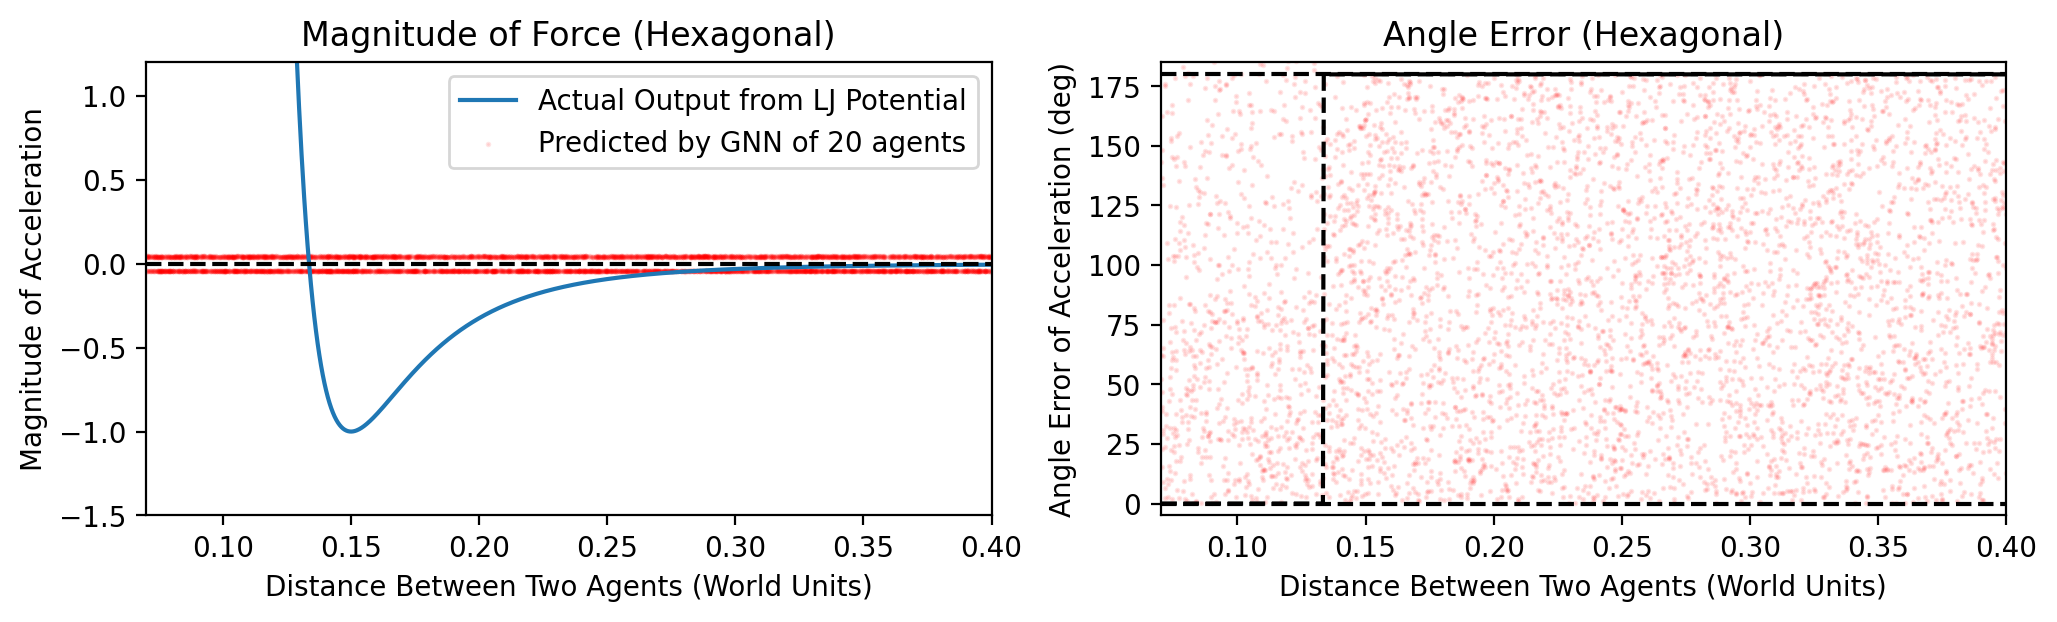

 20%|██        | 1/5 [00:28<01:54, 28.67s/it]

|D_error|0.8132615685462952	|G_error|0.31326165795326233


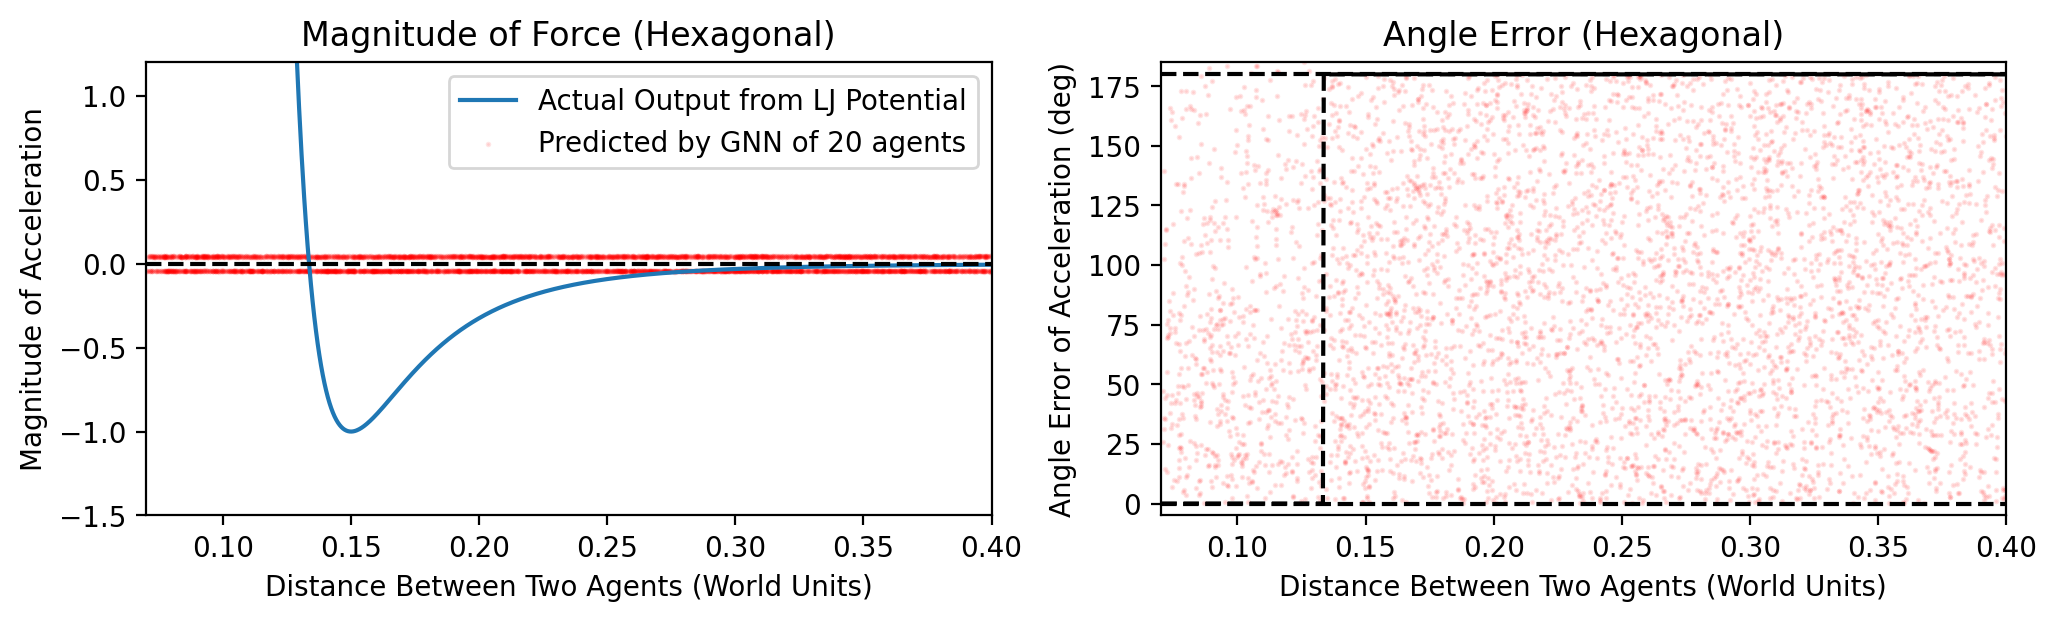

 40%|████      | 2/5 [00:57<01:25, 28.66s/it]

|D_error|0.8132616281509399	|G_error|0.31326165795326233


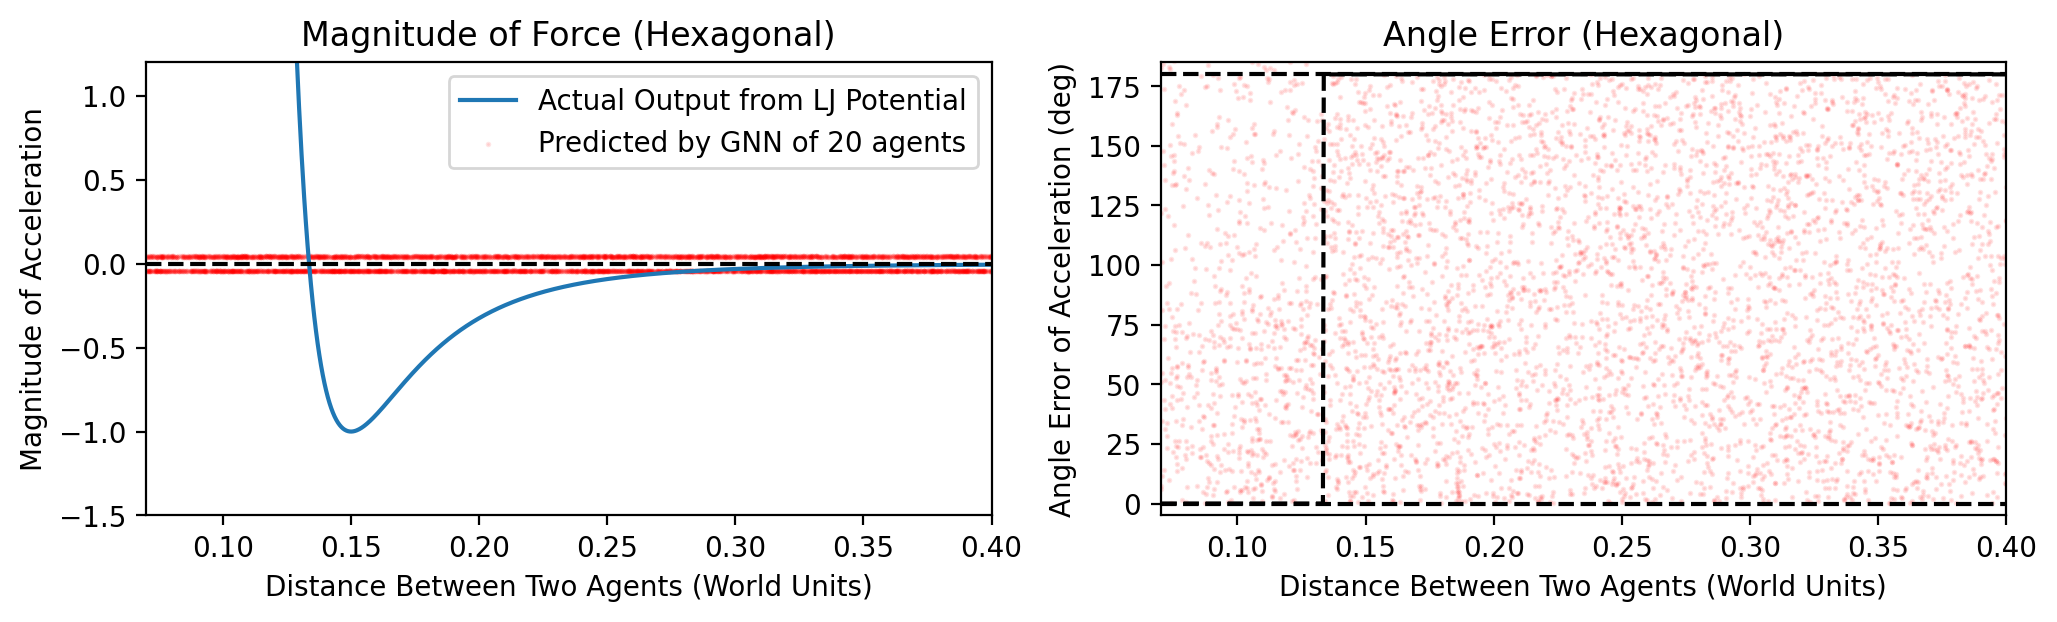

 60%|██████    | 3/5 [01:25<00:57, 28.67s/it]

|D_error|0.8132616281509399	|G_error|0.31326165795326233


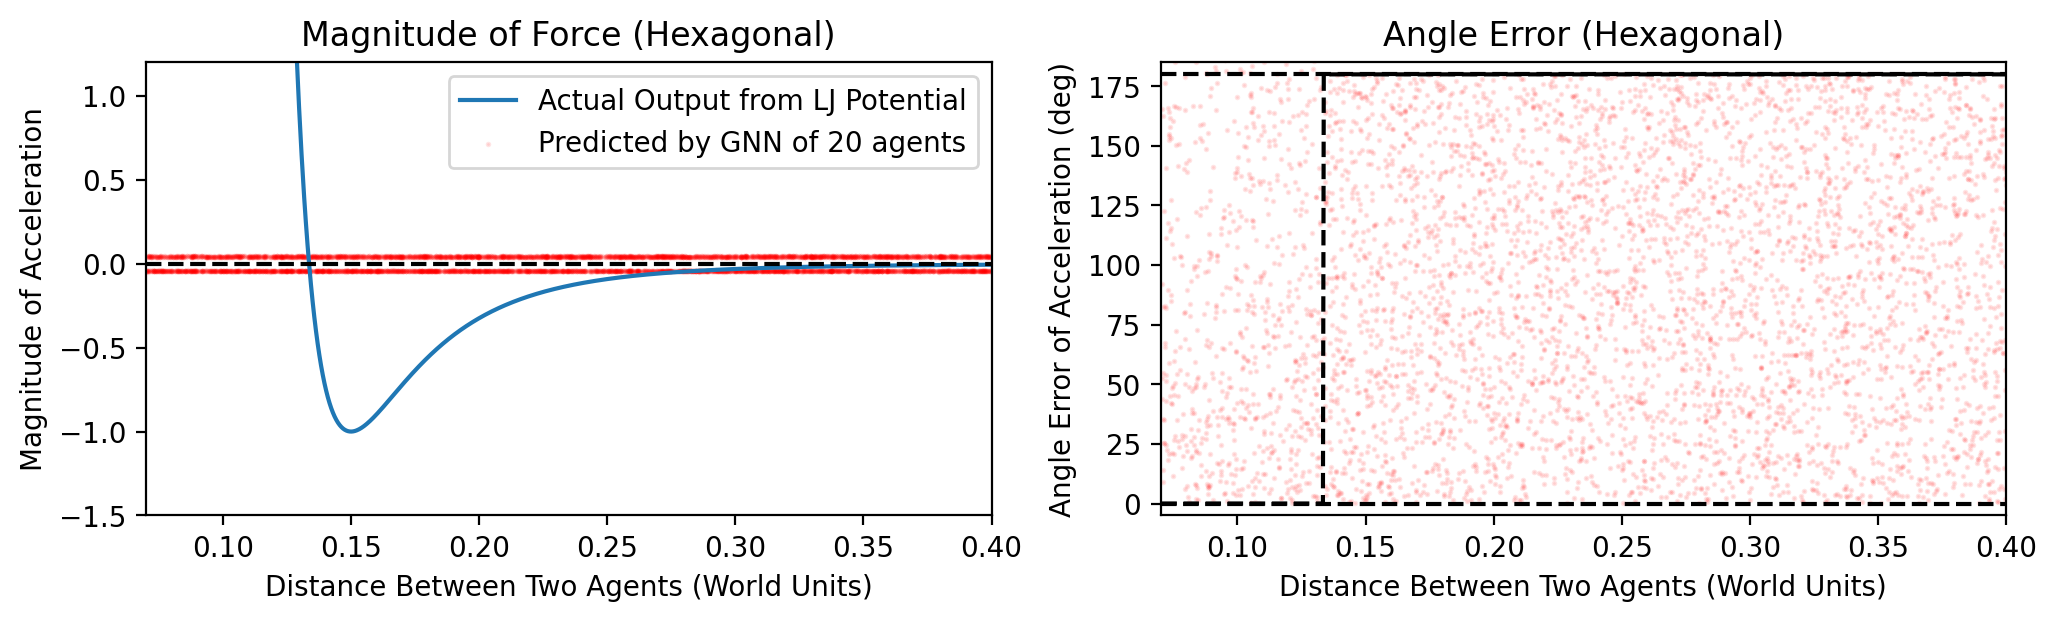

 80%|████████  | 4/5 [01:54<00:28, 28.68s/it]

|D_error|0.8132615685462952	|G_error|0.31326165795326233


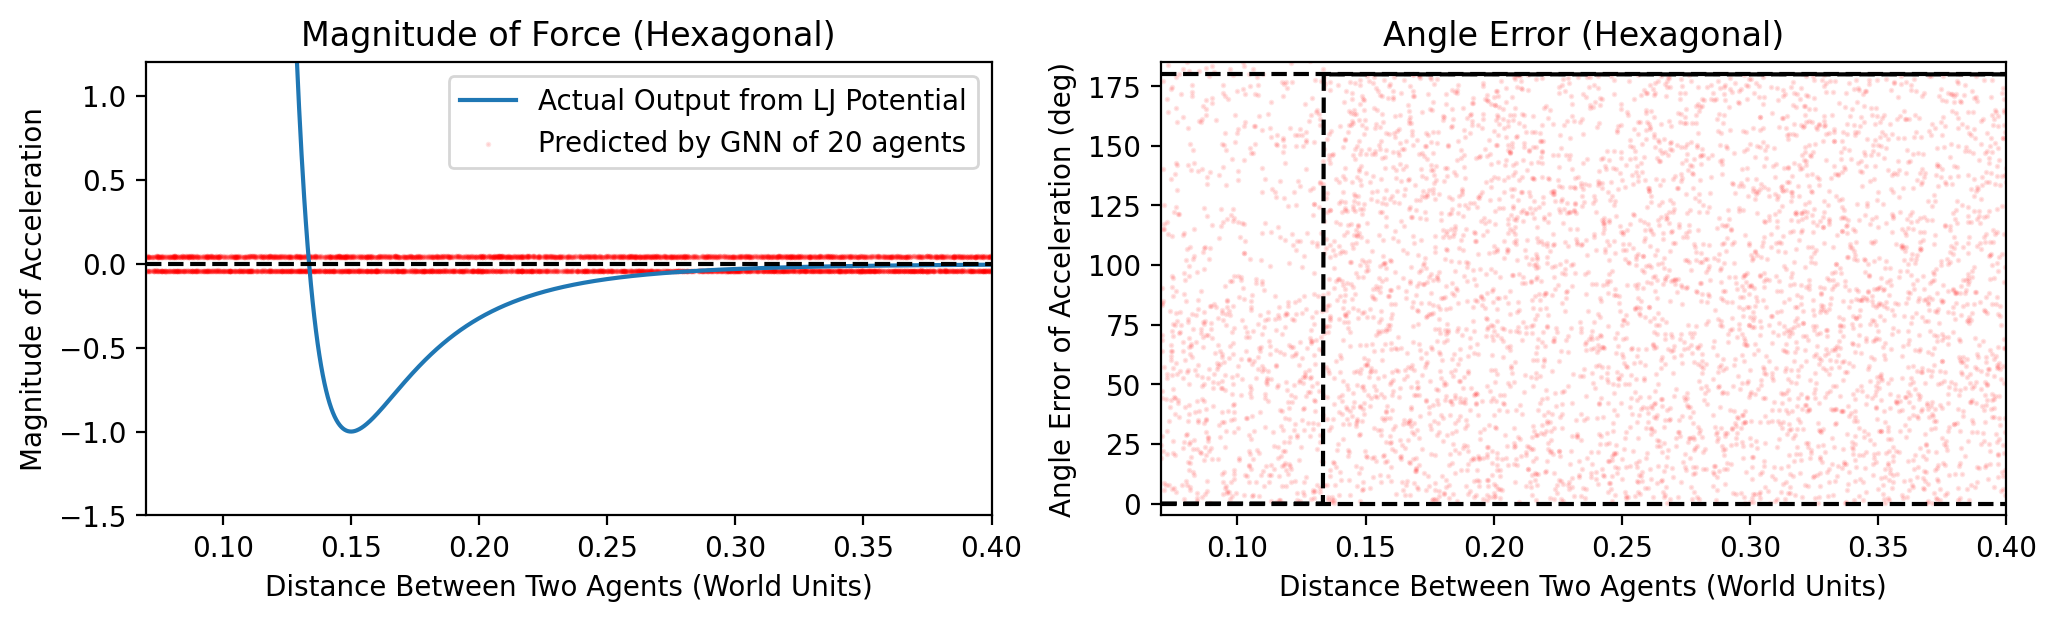

100%|██████████| 5/5 [02:23<00:00, 28.69s/it]


In [161]:
num_epochs = 5

d_error=0
g_error=0

from tqdm import tqdm 

for epoch in tqdm(range(num_epochs)):
    
    for row in trainLoader:
        row.to(device)
        
        # 1. Train Generator
        g_optimizer.zero_grad()

        generated_y = G(row.x, row.edge_index, batch=row.batch)
        #print(generated_y)
        #print(generated_y.shape)
        gd_out      = D(torch.cat([row.x, generated_y], dim=1), row.edge_index, batch=row.batch)
        #print(gd_out.shape)
        #print(gd_out)
        g_error     = loss(gd_out, torch.ones(gd_out.size()).to(device))
                
        g_error.backward()
        g_optimizer.step()
        
        # 2. Train Discriminator
        d_optimizer.zero_grad()
        
        true_d_out   = D(torch.cat([row.x, row.y], dim=1), row.edge_index, batch=row.batch)
        false_d_out  = D(torch.cat([row.x, generated_y.detach()], dim=1), row.edge_index, batch=row.batch)
        true_d_loss  = loss(true_d_out, torch.ones(true_d_out.size()).to(device))
        false_d_loss = loss(false_d_out, torch.zeros(false_d_out.size()).to(device))
        d_error      = (true_d_loss + false_d_loss) / 2
        
        d_error.backward()
        d_optimizer.step()
        
        # 3. Check
        #print(torch.cat([row.y, generated_y], dim=1))
    
    print("|D_error|"+str(d_error.item())+"\t|G_error|"+str(g_error.item()))
    showProgressGraphs(G)